In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math

from Data import *
from nets.MLP import MLP
from flows.build import build_flow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Base distribution

In [3]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device),
    )

In [4]:
batch_size = 2
Data = Data('two_moons.csv')

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

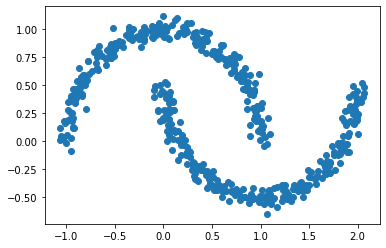

In [5]:
Data.plot_scatter()

## RealNVP

In [6]:
net = MLP(ip = 1, out = 2)
# net
def make_net():
    return nn.Sequential(nn.Linear(1,256), nn.GELU(),
                       nn.Linear(256,128), nn.GELU(),
                       nn.Linear(128,2))

In [7]:
flow_realnvp = build_flow(name = 'realnvp', net = make_net(), dim= 7, device = device).flow.to(device)
# print(flow_realnvp)

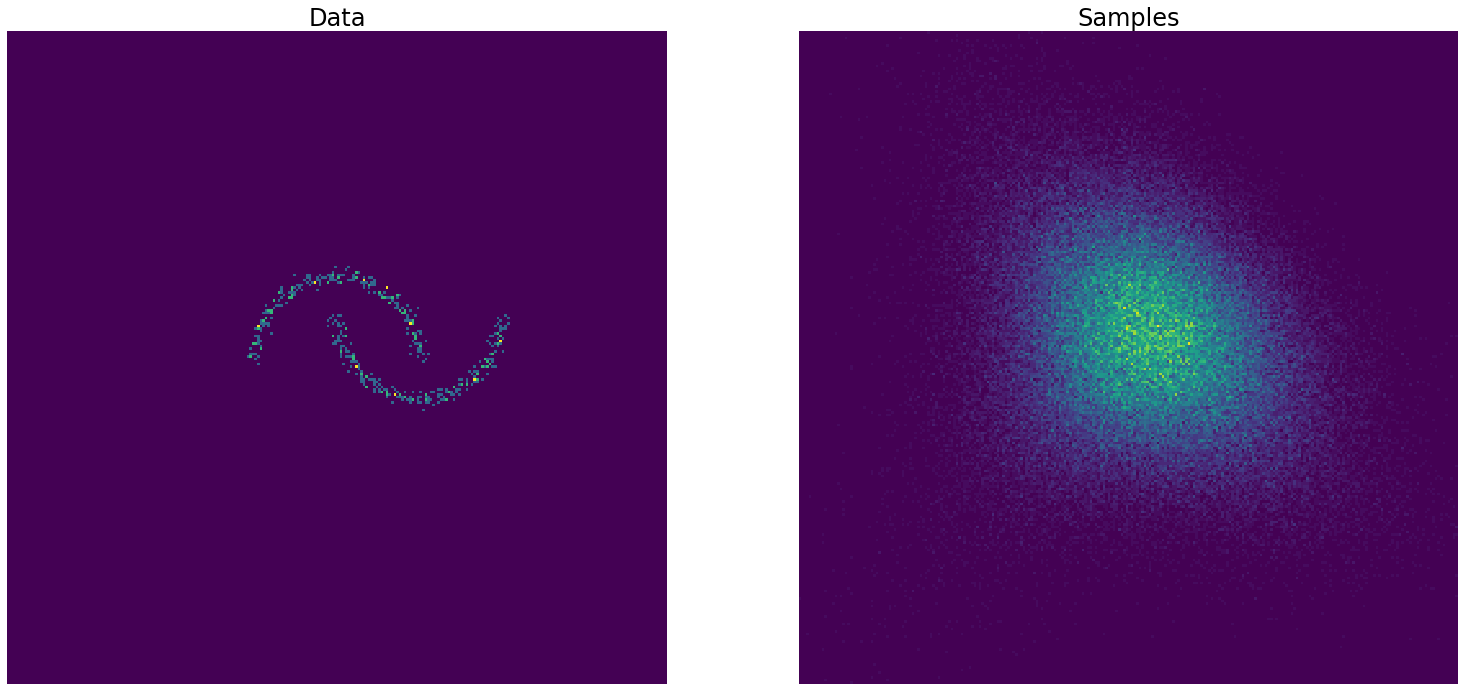

In [8]:
Data.plot_samples(flow_realnvp.sample(128000))

In [ ]:
#Train

optimizer = torch.optim.Adam(flow_realnvp.parameters(), lr=1e-3)
epochs = 500

print('Training...')
flow_realnvp = flow_realnvp.train()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        z, log_det = flow_realnvp.flow_outputs(x)
        if torch.isnan(z).any() : 
            continue
        log_prob = base_dist().log_prob(z).sum(1) + log_det
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
flow_realnvp = flow_realnvp.eval()

Training...
Epoch: 1/500, Loss: 2.182
Epoch: 2/500, Loss: 1.967
Epoch: 3/500, Loss: 1.935
Epoch: 4/500, Loss: 1.930
Epoch: 5/500, Loss: 1.966
Epoch: 6/500, Loss: 1.900
Epoch: 7/500, Loss: 2.917
Epoch: 8/500, Loss: 2.004
Epoch: 9/500, Loss: 2.281
Epoch: 10/500, Loss: 1.968
Epoch: 11/500, Loss: 1.862
Epoch: 12/500, Loss: 1.682
Epoch: 13/500, Loss: 1.884
Epoch: 14/500, Loss: 1.636
Epoch: 15/500, Loss: 1.869
Epoch: 16/500, Loss: 1.723
Epoch: 17/500, Loss: 1.603
Epoch: 18/500, Loss: 1.637
Epoch: 19/500, Loss: 1.607
Epoch: 20/500, Loss: 1.614
Epoch: 21/500, Loss: 1.960
Epoch: 22/500, Loss: 1.745
Epoch: 23/500, Loss: 1.639
Epoch: 24/500, Loss: 1.615
Epoch: 25/500, Loss: 1.590
Epoch: 26/500, Loss: 1.740
Epoch: 27/500, Loss: 1.593
Epoch: 28/500, Loss: 2.842
Epoch: 29/500, Loss: 2.028
Epoch: 30/500, Loss: 1.760
Epoch: 31/500, Loss: 1.741
Epoch: 32/500, Loss: 1.665
Epoch: 33/500, Loss: 1.630
Epoch: 34/500, Loss: 1.670
Epoch: 35/500, Loss: 1.653
Epoch: 36/500, Loss: 1.573
Epoch: 37/500, Loss: 1.64

In [ ]:
Data.plot_samples(flow_realnvp.sample(128000))

In [ ]:
# if batch_num % 10 == 0:
#     print(f"(batch_num {batch_num:05d}/{num_batches}) loss: {loss}")